# Importation

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.linear_model import LinearRegression

from tqdm.notebook import tqdm
tqdm.pandas

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

# Load data

In [22]:
employee = pd.read_csv(os.path.join("..","..","..", "data","attrition", "employee_process.csv"))

In [23]:
X = employee.copy()
X.head()

,age,y,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,...,jobrole_laboratory_technician,jobrole_manager,jobrole_manufacturing_director,jobrole_research_director,jobrole_research_scientist,jobrole_sales_executive,jobrole_sales_representative,maritalstatus_divorced,maritalstatus_married,maritalstatus_single
0,41,1,1102,1,2,2,0,94,3,2,...,0,0,0,0,0,1,0,0,0,1
1,49,0,279,8,1,3,1,61,2,2,...,0,0,0,0,1,0,0,0,1,0
2,37,1,1373,2,2,4,1,92,2,1,...,1,0,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,4,0,56,3,1,...,0,0,0,0,1,0,0,0,1,0
4,27,0,591,2,1,1,1,40,3,1,...,1,0,0,0,0,0,0,0,1,0


In [24]:
augmentation =[ ]
for var in X.columns :
    if X[var].unique().tolist() == [0,1] :
        pass
    elif X[var].unique().tolist() ==[1,0]:
        pass
    else :
        augmentation.append(var)

In [25]:
X_nl = X.copy()

for var in augmentation :
    
    X_nl[var+'_squared'] = X_nl[var]**2
    X_nl[var+'_cube'] = X_nl[var]**3

In [26]:
for i in range(len(augmentation)-1):
     X_nl[augmentation[i]+'_'+augmentation[i+1]] = X_nl[augmentation[i]]*X_nl[augmentation[i+1]]

In [27]:
scaler = MinMaxScaler()
X_process = scaler.fit_transform(X_nl)
X_process = pd.DataFrame(X_process, columns = X_nl.columns)

In [28]:
print(X_process.shape)
X_process.head()

(1470, 118)


,age,y,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,...,percentsalaryhike_performancerating,performancerating_relationshipsatisfaction,relationshipsatisfaction_stockoptionlevel,stockoptionlevel_totalworkingyears,totalworkingyears_trainingtimeslastyear,trainingtimeslastyear_worklifebalance,worklifebalance_yearsatcompany,yearsatcompany_yearsincurrentrole,yearsincurrentrole_yearssincelastpromotion,yearssincelastpromotion_yearswithcurrmanager
0,0.547619,1.0,0.715820,0.000000,0.25,0.333333,0.0,0.914286,0.666667,0.25,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.044118,0.040404,0.000000,0.000000
1,0.738095,0.0,0.126700,0.250000,0.00,0.666667,1.0,0.442857,0.333333,0.25,...,0.880597,1.000000,0.333333,0.092593,0.138889,0.375,0.220588,0.117845,0.025926,0.027451
2,0.452381,1.0,0.909807,0.035714,0.25,1.000000,1.0,0.885714,0.333333,0.00,...,0.179104,0.230769,0.000000,0.000000,0.097222,0.375,0.000000,0.000000,0.000000,0.000000
3,0.357143,0.0,0.923407,0.071429,0.75,1.000000,0.0,0.371429,0.666667,0.00,...,0.000000,0.461538,0.000000,0.000000,0.111111,0.375,0.176471,0.094276,0.077778,0.000000
4,0.214286,0.0,0.350036,0.035714,0.00,0.000000,1.0,0.142857,0.666667,0.00,...,0.044776,0.692308,0.333333,0.055556,0.083333,0.375,0.044118,0.006734,0.014815,0.015686


# Méthode 1


## Reduction of dimension by PCA

In [29]:
from sklearn.decomposition import PCA #PCA
from sklearn.cluster import KMeans, DBSCAN #clustering methods

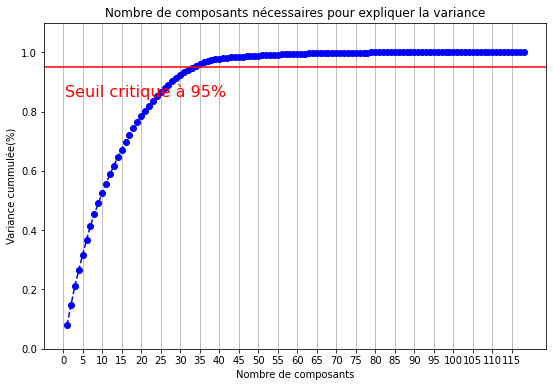

In [31]:
pca = PCA().fit(X_process)

plt.rcParams["figure.figsize"] = (9,6)

fig, ax = plt.subplots()
xi = np.arange(1, 119, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Nombre de composants')
plt.xticks(np.arange(0, 119, step=5)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Variance cummulée(%)')
plt.title('Nombre de composants nécessaires pour expliquer la variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, 'Seuil critique à 95%', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [33]:
def pca(X):
    pca = PCA(35)
    newX = pca.fit_transform(X)
    newdf = pd.DataFrame(newX)
    newdf.to_pickle('pca.p')
    return (newdf)

In [35]:
X_pca = pca(X_process)
print(X_pca.shape)
X_pca.head()

(1470, 35)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.317932,-1.286873,0.221182,-0.760401,0.284141,0.880269,-0.622254,-0.668516,-0.441350,1.221628,...,0.010273,0.148327,0.188769,-0.113638,-0.043112,0.009306,-0.387500,-0.038716,-0.063941,0.095292
1,-0.539803,1.330674,1.389539,0.941571,-0.281972,-0.290034,0.201123,-0.783759,0.534634,-1.239484,...,0.085138,-0.375420,-0.431106,0.459742,-0.202858,-0.081565,-0.090135,-0.072538,0.164285,0.062288
2,-1.060399,-0.140407,-0.595107,0.138932,1.054725,-0.029526,-0.484657,0.112653,-0.485187,0.667343,...,-0.187112,-0.247673,0.012497,0.007128,-0.114148,0.178696,0.069666,-0.406563,-0.076819,0.810581
3,-0.572947,0.113506,-0.807933,0.279858,0.728884,0.050908,0.463569,-0.682794,0.344865,-0.925912,...,-0.038414,-0.016781,-0.455632,-0.168183,-0.024809,0.180194,0.103602,0.035440,-0.071556,-0.184520
4,-0.651710,0.122759,-0.478512,0.367285,-1.598269,-0.440367,0.195344,0.724155,-0.488413,-0.249543,...,-0.061616,-0.131320,-0.160026,-0.245148,0.019134,0.278245,0.305123,0.193903,-0.170122,-0.167330


## Use of Kmeans to cluster

In [37]:
K = range(1,50)
SSE = []
for k in tqdm(K, total = len(K)):
    clustering = KMeans(n_clusters = k)
    clustering.fit(X_pca.values.astype(float))
    SSE.append(clustering.inertia_)

  0%|          | 0/49 [00:00<?, ?it/s]

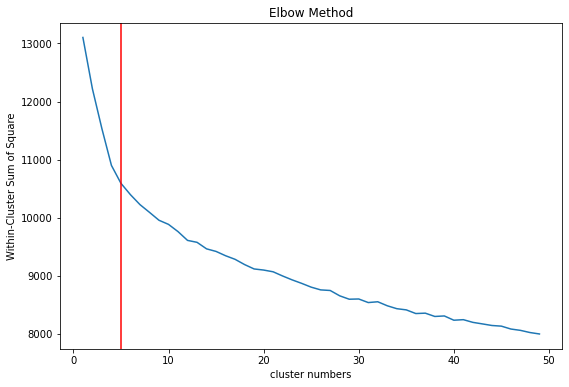

In [46]:
import matplotlib.pyplot as plt
plt.plot(K,SSE,)

plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.ylabel('Within-Cluster Sum of Square')
plt.axvline(x = 5, c='r')
plt.show()

In [41]:
k_cluster = 5
clustering = KMeans(n_clusters=k_cluster).fit(X_pca.values.astype(float))

In [42]:
X['Cluster'] = clustering.labels_

In [43]:
moyenne_cluster = []
for k in range(k_cluster):
    df = X[X['Cluster']== k]
    moyenne=[]
    for var in X.columns.tolist() :
        moyenne.append(np.mean((df[var])))
    moyenne_cluster.append(moyenne)

In [45]:
interpret = pd.DataFrame({
    "Variable" : X.columns.tolist(),
    "Cluster_0" : moyenne_cluster[0],
    "Cluster_1" : moyenne_cluster[1],
    "Cluster_2" : moyenne_cluster[2],
    "Cluster_3" : moyenne_cluster[3],
    "Cluster_4" : moyenne_cluster[4],
})
interpret

,Variable,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,age,47.827586,33.983122,35.943548,35.428977,36.033175
1,y,0.063218,0.202532,0.125000,0.224432,0.175355
2,dailyrate,813.551724,753.092827,826.872984,799.659091,796.227488
3,distancefromhome,8.160920,8.535865,9.491935,9.380682,9.763033
4,education,3.068966,2.894515,2.895161,2.920455,2.834123
5,environmentsatisfaction,2.787356,2.738397,2.733871,2.713068,2.635071
6,gender,0.557471,0.573840,0.633065,0.596591,0.592417
7,hourlyrate,65.816092,66.164557,66.300403,65.352273,65.582938
8,jobinvolvement,2.724138,2.717300,2.786290,2.687500,2.687204
9,joblevel,4.275862,1.531646,1.637097,2.065341,1.838863
